## This Notebook contains ImageNet models implemented to detect endometriosis using the Image GLENDA: Gynecologic Laparoscopy Endometriosis Dataset

### ImageNet Models:
- MobileNetV3 Small
- MobileNetV3 Large
- NASNetMobile
- EfficientNetV2 B0
- DenseNet121
- ResNet50
- ResNet50V2
- InceptionV3
- Xception
- InceptionResNetV2
- VGG16

In [2]:
## Imports
import os
import shutil
import uuid
import cv2
import warnings
import keras
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow Imports
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large, NASNetMobile, EfficientNetB0, EfficientNetV2B0, ConvNeXtTiny, DenseNet121, ResNet50V2, ConvNeXtSmall, ConvNeXtSmall, ConvNeXtBase, InceptionV3, Xception, InceptionResNetV2, VGG16 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

## Sklearn Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

# Preparing the Datasets

The original stucture of the dataset is set so that the images are located in seperate subfolders (1 image each folder). They are already seperated between pathology and non-pathology images (positive and negative examples of endometriosis).

Thus, we must extract the files from the subfolders so that all pathology and non-pathology images are in 2 subfolders ready for training.

In [3]:
#Move files from subfolders into pathology and healthy datasets

def extract_files_from_subfolders(root_directory, destination_directory):
    """
    Extracts files from subfolders in the root directory
    and places them into one folder aka destination directory. 
    The files are assigned a new random name to avoid overwriting.
    """
    for folder in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(root_directory, folder, filename)
            dest_path = os.path.join(destination_directory, filename+str(uuid.uuid4()))
            shutil.copy(file_path, dest_path)
            print("Copied ", file_path, "to", dest_path)

In [4]:
# #extract the pathology images to pathology_train folder
# extract_files_from_subfolders('C:/Users/vella/Mastes Thesis/raw_data/Glenda/GLENDA_v1.0 (1)/GLENDA_v1.0/DS/pathology/frames',
#                               'C:/Users/vella/Mastes Thesis/processed_data/pathology_train')

In [5]:
# #extract the non pathology images to no_pathology_train folder
# extract_files_from_subfolders('C:/Users/vella/Mastes Thesis/raw_data/Glenda/GLENDA_v1.0 (1)/GLENDA_v1.0/DS/no_pathology/frames',
#                               'C:/Users/vella/Mastes Thesis/processed_data/no_pathology_train')

In [6]:
import gc
del X  # Delete large variables
gc.collect()  # Free memory

NameError: name 'X' is not defined

In [8]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Try with 2000 samples from each class
X = []
y = []
classes = ['no_pathology_train', 'pathology_train']
base_path = 'C:/Users/vella/Mastes Thesis/processed_data/'

# Define Data Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'  # Fill in missing pixels
)

# Convert images into numpy arrays and apply augmentation
for i, target in enumerate(classes):
    files = base_path + target + '/'

    for file in os.listdir(files):
        # Load the image
        img = image.load_img(files + file)
        
        # Convert it to an array
        img_array = image.img_to_array(img, dtype='uint8')

        # Resize to 224x224
        img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

        # Reshape for augmentation (ImageDataGenerator expects shape (1, height, width, channels))
        img_array = np.expand_dims(img_array, axis=0)

        # Apply augmentation (Generate 1 augmented version per image) 
        #more than 1 image and will give an error
        #MemoryError: Unable to allocate 43.2 GiB for an array with shape (77046, 224, 224, 3) and data type float32
        augmented_image = datagen.flow(img_array, batch_size=1).next()[0]  # Extract augmented image

        # Append original & augmented image to X
        X.append(img_array[0])  # Original image
        X.append(augmented_image)  # Augmented image

        # Append the target to y (Twice, for original & augmented)
        y.append(target)
        y.append(target)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
y_dict = {'no_pathology_train': 0, 'pathology_train': 1}
y = np.vectorize(y_dict.get)(y)

print(f"Dataset size after augmentation: {X.shape}, Labels: {y.shape}")


Dataset size after augmentation: (51364, 224, 224, 3), Labels: (51364,)


# Data Preprocessing

- Turn images into numpy arrays

In [9]:
# #Try with 2000 samples from each class

# X = []
# y = []
# classes = ['no_pathology_train', 'pathology_train']
# base_path = 'C:/Users/vella/Mastes Thesis/processed_data/'

# #Turn images into numpy arrays
# for i, target in enumerate(classes):
#     files = base_path+target+'/'
    
#     for file in os.listdir(files):
        
#         # load the image
#         img = image.load_img(files+file)
        
#         # convert it to an array
#         img_array = image.img_to_array(img, dtype='uint8')
        
#         # resize 
#         img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        
#         # append the array to X
#         X.append(img_array)
        
#         # append the target to y
#         y.append(target)


# X = np.array(X)
# y = np.array(y)

# y_dict = {'no_pathology_train':0, 'pathology_train':1}
# y = np.vectorize(y_dict.get)(y)

In [10]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

X.shape, y.shape
# y

((51364, 224, 224, 3), (51364,))

# Methods

- Image model method that initilizes, compiles, fits the models
- plot accuracy and loss curves from epochs
- evaluation metric 

In [11]:
def image_model(model_name, model_title, loss, activation):
    K.clear_session()

    init_model = model_name(include_top=False,
                         weights="imagenet",
                         pooling='avg',
                         input_tensor=Input(shape=(224, 224, 3)))

    print("\n\n--------------- Model Summary ---------------")

    init_model.summary()

    # freeze it!
    init_model.trainable = False

    len(classes)

    model = Sequential()
    model.add(init_model)

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(classes), activation=activation)) #!!! Final layer with a length of 2, and softmax activation 
   
    print("\n\n--------------- Model Summary ---------------")
    # have a look at the trainable and non-trainable params statistic
    model.summary()

    model.compile(optimizer=Adam(learning_rate=0.001),loss=loss,metrics=['accuracy'])
    
    print("\n\n--------------- Fitting ---------------")
    
    #Fit the data

    # Calculate the duration
    start_time = time.time()

    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        verbose=2,
                        callbacks=[callback],
                        # use 30% of the data for validation
                        validation_split=0.3)

    history.history

    # Calculate elapsed time
    elapsed_time = time.time() - start_time

    # Convert elapsed time to hours, minutes, and seconds
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Display the result
    print(f'\nProcess finished in {int(hours)}h {int(minutes)}m {seconds:.2f}s')
    
    # plot the accuracy and loss curves
    plot_curves(model_title, history.history)

    return model

In [12]:
def plot_curves(model_title, history):
    # Curve plots
    plt.figure(figsize=(12, 6))

    # Accuracy curve plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss curve plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # Main title for the entire figure
    plt.suptitle(f"{model_title} Accuracy and Loss Curve Plot", fontsize=16)
    
    # Show the plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  
    plt.show()

In [13]:
## evaluation functions 

def evaluate(ytest, ypred, xtrain, ytrain):
    
    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)
    recall = recall_score(ytest, ypred)
    f1score = f1_score(ytest, ypred)
    auc = roc_auc_score(ytest, ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'\nClassification Report: ')
    print(classification_report(ytest, ypred, target_names=['0 -  Negative (No Pathology)', '1 - Positive (Pathology)']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
        
    return accuracy, precision, recall, f1score, auc

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape

# convert to binary
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((41091, 224, 224, 3), (41091, 2), (10273, 224, 224, 3), (10273, 2))

In [15]:
# For results
model_results = pd.DataFrame({'Metrics':['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROC AUC']})
model_results.head()

,Metrics
0,Accuracy
1,Precision
2,Recall
3,F1Score
4,ROC AUC


# Model Training
## MobileNetV3 Small



--------------- Model Summary ---------------
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                   

 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_4 (ReLU)                 (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 28, 28, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_4[0][0]',             
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 14, 14, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 14, 14, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 14, 14, 144)  3600       ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 14, 14, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 14, 14, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_18 (TFOpL  (None, 7, 7, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_23 (ReLU)                (None, 7, 7, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 7, 7, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 7, 7, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)   0           ['re_lu_30[0][0]']               
 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 7, 7, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 7, 7, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_

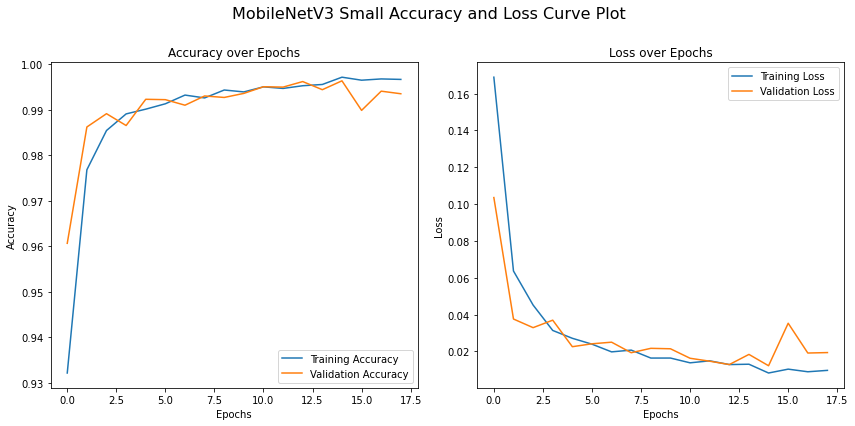

In [11]:
MobileNetV3Small_model = image_model(MobileNetV3Small, 'MobileNetV3 Small' ,'categorical_crossentropy', 'softmax')

MobileNetV3Small_model.save('models/MobileNetV3Small_model.keras')

322/322 [==============================] - 114s 333ms/step

--------------- Evaluation ---------------
Accuracy: 0.996
Precision: 0.997
Recall: 0.994
F1 Score: 0.996
ROC AUC: 0.996

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       1.00      1.00      1.00      5420
    1 - Positive (Pathology)       1.00      0.99      1.00      4853

                    accuracy                           1.00     10273
                   macro avg       1.00      1.00      1.00     10273
                weighted avg       1.00      1.00      1.00     10273


--------------- Visual Evaluation ---------------


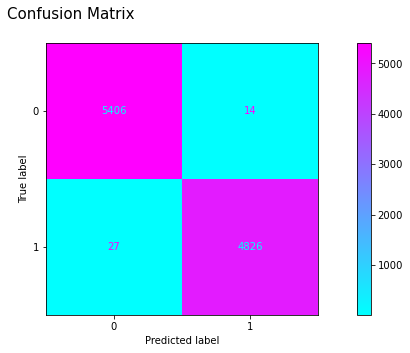

In [12]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = MobileNetV3Small_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Small'] = results
#model_results

## MobileNetV3 Large



--------------- Model Summary ---------------
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

Epoch 8/50
899/899 - 492s - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9964 - 492s/epoch - 547ms/step
Epoch 9/50
899/899 - 502s - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.0093 - val_accuracy: 0.9973 - 502s/epoch - 559ms/step
Epoch 10/50
899/899 - 530s - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0074 - val_accuracy: 0.9979 - 530s/epoch - 590ms/step
Epoch 11/50
899/899 - 479s - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.0074 - val_accuracy: 0.9980 - 479s/epoch - 533ms/step
Epoch 12/50
899/899 - 479s - loss: 0.0096 - accuracy: 0.9965 - val_loss: 0.0178 - val_accuracy: 0.9955 - 479s/epoch - 533ms/step
Epoch 13/50
899/899 - 476s - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0096 - val_accuracy: 0.9976 - 476s/epoch - 529ms/step

Process finished in 1h 49m 30.03s


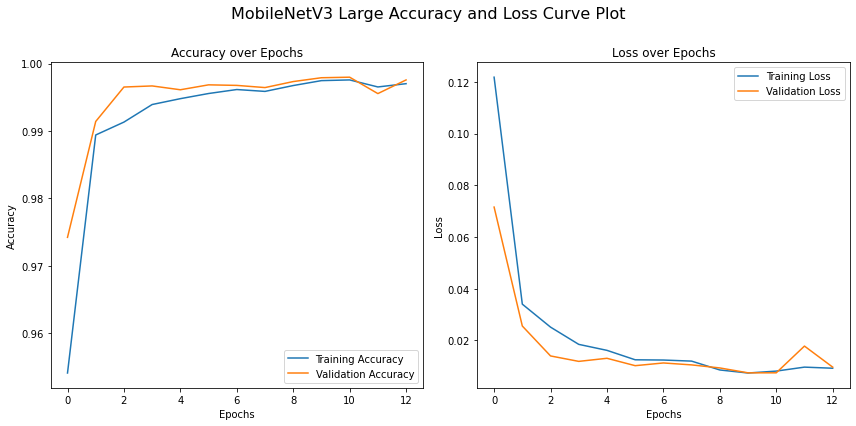

In [15]:
MobileNetV3Large_model = image_model(MobileNetV3Large, 'MobileNetV3 Large', 'categorical_crossentropy', 'softmax')

MobileNetV3Large_model.save('models/MobileNetV3Large_model.keras')  

322/322 [==============================] - 129s 397ms/step

--------------- Evaluation ---------------
Accuracy: 0.998
Precision: 0.998
Recall: 0.998
F1 Score: 0.998
ROC AUC: 0.998

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       1.00      1.00      1.00      5420
    1 - Positive (Pathology)       1.00      1.00      1.00      4853

                    accuracy                           1.00     10273
                   macro avg       1.00      1.00      1.00     10273
                weighted avg       1.00      1.00      1.00     10273


--------------- Visual Evaluation ---------------


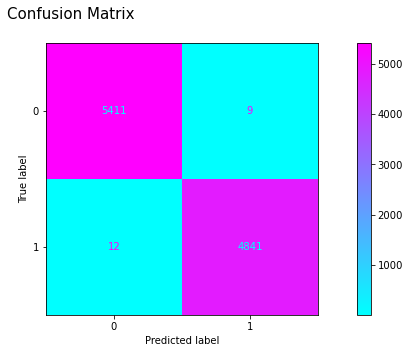

In [16]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = MobileNetV3Large_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Large'] = results
#model_results

## NASNetMobile

In [19]:
NASNetMobile_model = image_model(NASNetMobile, 'NASNetMobile', 'categorical_crossentropy', 'softmax')

NASNetMobile_model.save('models/NASNetMobile_model.keras')  



--------------- Model Summary ---------------
Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )            

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add (Add)                      (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 111, 111, 32  0           ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_16[0][0]']          
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_18 (Activation)     (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_24 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_33 (Activation)     (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_34 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_40[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_42[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_44[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_55 (Activation)     (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_47[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_49[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_51[0][0]']          
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_60 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_62 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_64 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_70 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_69 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_70[0][0]']          
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_69[0][0]']          
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_79[0][0]']          
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 28, 28, 264)  0           ['zero_padding2d_2[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_2[0][0]',                 
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_89 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_83[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_94 (Activation)     (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_96 (Activation)     (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_119[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_121[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_123[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_130 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_132 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_130[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_132[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_140 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_148[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_150[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_153[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_155[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_157[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_159[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_166 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_168 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_170 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_172 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_176 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_175[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_176[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 7, 7, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

KeyboardInterrupt: 

In [ ]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = NASNetMobile_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['NASNetMobile'] = results
#model_results

## EfficientNetV2B0



--------------- Model Summary ---------------
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (N

 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_a

 block4b_add (Add)              (None, 14, 14, 96)   0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block5b_dwconv2 (DepthwiseConv  (None, 14, 14, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_s

 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_s

 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
          

                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 192)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 192)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6f_expand_conv[0][0]']    
 ization) 

                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_d

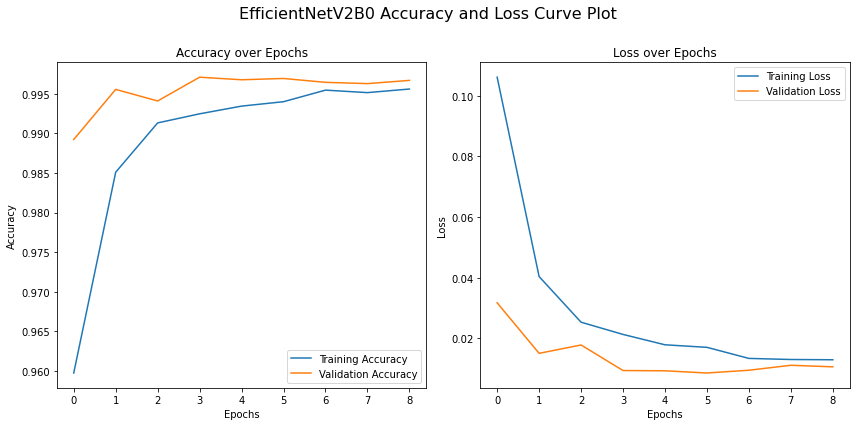

In [20]:
EfficientNetV2B0_model = image_model(EfficientNetV2B0, 'EfficientNetV2B0', 'categorical_crossentropy', 'softmax')

EfficientNetV2B0_model.save('models/EfficientNetV2B0_model.keras')  

322/322 [==============================] - 154s 471ms/step

--------------- Evaluation ---------------
Accuracy: 0.995
Precision: 0.993
Recall: 0.996
F1 Score: 0.995
ROC AUC: 0.995

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       1.00      0.99      1.00      5420
    1 - Positive (Pathology)       0.99      1.00      0.99      4853

                    accuracy                           1.00     10273
                   macro avg       0.99      1.00      1.00     10273
                weighted avg       1.00      1.00      1.00     10273


--------------- Visual Evaluation ---------------


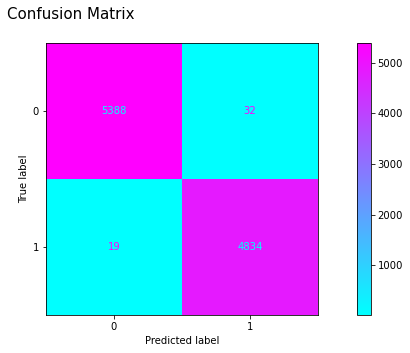

In [21]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = EfficientNetV2B0_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['EfficientNetV2B0'] = results
#model_results

## DenseNet121



--------------- Model Summary ---------------
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 7,168,962
Trainable params: 131,458
Non-trainable params: 7,037,504
_________________________________________________________________


--------------- Fitting ---------------
Epoch 1/50
899/899 - 1623s - loss: 0.4604 - accuracy: 0.7880 - val_loss: 0.3157 - val_accuracy: 0.8621 - 1623s/epoch - 2s/step
Epoch 2/50
899/899 - 2574s - loss: 0.2939 - accuracy: 0.8734 - val_loss: 0.2179 - val_accuracy: 0.9090 - 2574s/epoch - 3s/step
Epoch 3/50
899/899 - 1682s -

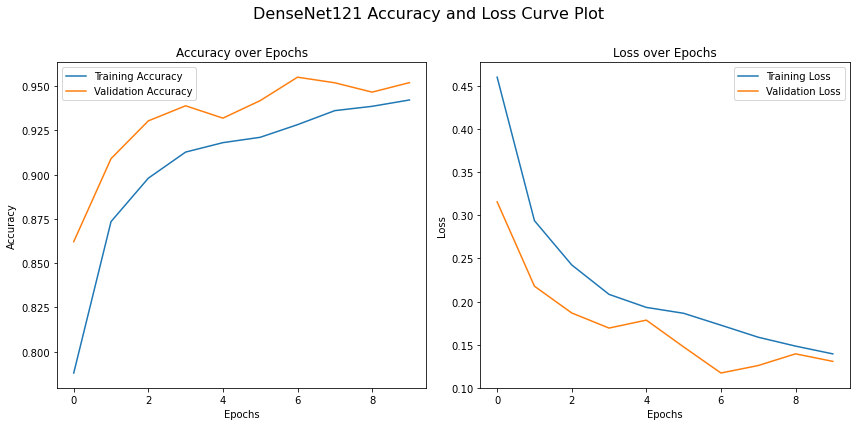

In [22]:
DenseNet121_model = image_model(DenseNet121, 'DenseNet121', 'categorical_crossentropy', 'softmax')

DenseNet121_model.save('models/DenseNet121_model.keras')  

322/322 [==============================] - 477s 1s/step

--------------- Evaluation ---------------
Accuracy: 0.957
Precision: 0.957
Recall: 0.952
F1 Score: 0.954
ROC AUC: 0.957

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.96      0.96      0.96      5420
    1 - Positive (Pathology)       0.96      0.95      0.95      4853

                    accuracy                           0.96     10273
                   macro avg       0.96      0.96      0.96     10273
                weighted avg       0.96      0.96      0.96     10273


--------------- Visual Evaluation ---------------


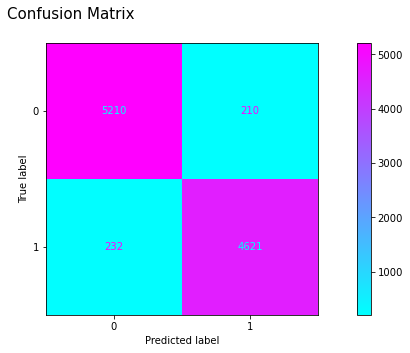

In [23]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = DenseNet121_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['DenseNet121'] = results
#model_results

## ResNet50

In [27]:
ResNet50_model = image_model(ResNet50, 'ResNet50', 'categorical_crossentropy', 'softmax')

ResNet50_model.save('models/ResNet50_model.keras')  



--------------- Model Summary ---------------
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/resnet50/conv2_block1_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\vella\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\vella\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\vella\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\vella\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\vella\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\vella\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\vella\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\vella\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\vella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\vella\AppData\Local\Temp/ipykernel_14744/467987473.py", line 1, in <cell line: 1>
      ResNet50_model = image_model(ResNet50, 'ResNet50', 'categorical_crossentropy', 'softmax')
    File "C:\Users\vella\AppData\Local\Temp/ipykernel_14744/3018791475.py", line 41, in image_model
      history = model.fit(X_train, y_train,
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\vella\AppData\Roaming\Python\Python39\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/resnet50/conv2_block1_0_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,56,56,256] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential/resnet50/conv2_block1_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_347554]

In [ ]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = ResNet50_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50'] = results
#model_results

## ResNet50V2



--------------- Model Summary ---------------
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                         

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

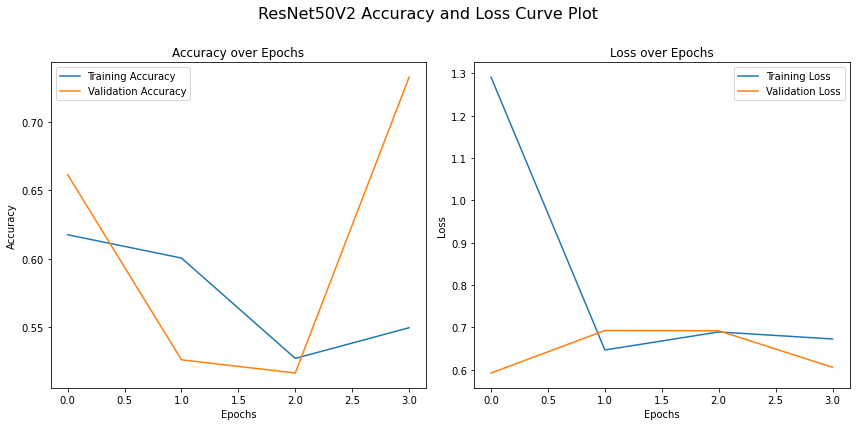

In [25]:
ResNet50V2_model = image_model(ResNet50V2, 'ResNet50V2', 'categorical_crossentropy', 'softmax')

ResNet50V2_model.save('models/ResNet50V2_model.keras')  

322/322 [==============================] - 285s 881ms/step

--------------- Evaluation ---------------
Accuracy: 0.67
Precision: 0.763
Recall: 0.434
F1 Score: 0.553
ROC AUC: 0.657

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.64      0.88      0.74      5431
    1 - Positive (Pathology)       0.76      0.43      0.55      4842

                    accuracy                           0.67     10273
                   macro avg       0.70      0.66      0.65     10273
                weighted avg       0.70      0.67      0.65     10273


--------------- Visual Evaluation ---------------


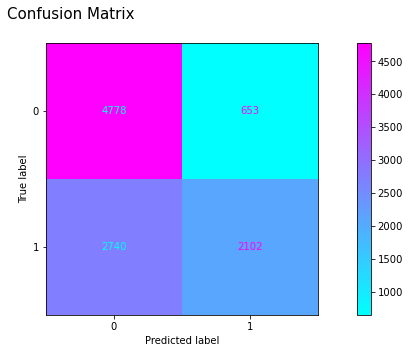

In [26]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = ResNet50V2_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50V2'] = results
#model_results

## InceptionV3



--------------- Model Summary ---------------
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

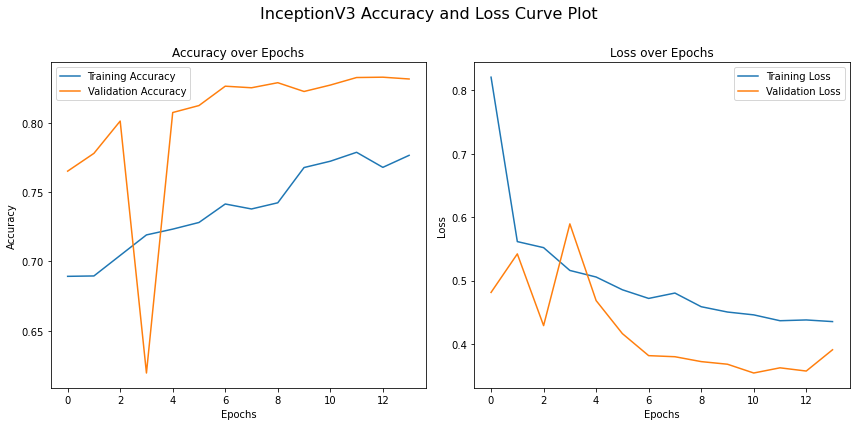

In [16]:
InceptionV3_model = image_model(InceptionV3, 'InceptionV3', 'categorical_crossentropy', 'softmax')

InceptionV3_model.save('models/InceptionV3_model.keras')  

322/322 [==============================] - 161s 498ms/step

--------------- Evaluation ---------------
Accuracy: 0.829
Precision: 0.844
Recall: 0.783
F1 Score: 0.812
ROC AUC: 0.827

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.82      0.87      0.84      5431
    1 - Positive (Pathology)       0.84      0.78      0.81      4842

                    accuracy                           0.83     10273
                   macro avg       0.83      0.83      0.83     10273
                weighted avg       0.83      0.83      0.83     10273


--------------- Visual Evaluation ---------------


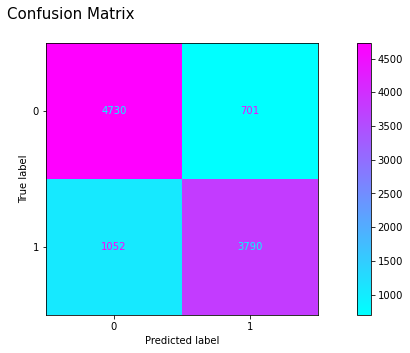

In [20]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = InceptionV3_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionV3'] = results
#model_results

## Xception



--------------- Model Summary ---------------
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

Epoch 7/50
899/899 - 1231s - loss: 0.3520 - accuracy: 0.8429 - val_loss: 0.2941 - val_accuracy: 0.8746 - 1231s/epoch - 1s/step
Epoch 8/50
899/899 - 1231s - loss: 0.3612 - accuracy: 0.8342 - val_loss: 0.3135 - val_accuracy: 0.8634 - 1231s/epoch - 1s/step
Epoch 9/50
899/899 - 1229s - loss: 0.3413 - accuracy: 0.8480 - val_loss: 0.3153 - val_accuracy: 0.8546 - 1229s/epoch - 1s/step
Epoch 10/50
899/899 - 1228s - loss: 0.3384 - accuracy: 0.8419 - val_loss: 0.2928 - val_accuracy: 0.8683 - 1228s/epoch - 1s/step
Epoch 11/50
899/899 - 1234s - loss: 0.3278 - accuracy: 0.8505 - val_loss: 0.2763 - val_accuracy: 0.8802 - 1234s/epoch - 1s/step
Epoch 12/50
899/899 - 1229s - loss: 0.3129 - accuracy: 0.8598 - val_loss: 0.2595 - val_accuracy: 0.8869 - 1229s/epoch - 1s/step
Epoch 13/50
899/899 - 1230s - loss: 0.3048 - accuracy: 0.8611 - val_loss: 0.2657 - val_accuracy: 0.8869 - 1230s/epoch - 1s/step
Epoch 14/50
899/899 - 1233s - loss: 0.3103 - accuracy: 0.8597 - val_loss: 0.2525 - val_accuracy: 0.8933 - 1

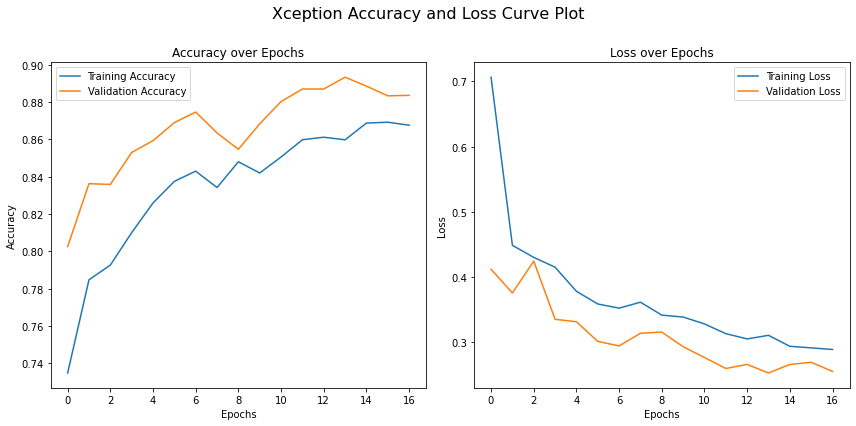

In [21]:
Xception_model = image_model(Xception,'Xception' , 'categorical_crossentropy', 'softmax')

Xception_model.save('models/Xception_model.keras')  

322/322 [==============================] - 311s 964ms/step

--------------- Evaluation ---------------
Accuracy: 0.898
Precision: 0.927
Recall: 0.85
F1 Score: 0.887
ROC AUC: 0.895

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.88      0.94      0.91      5431
    1 - Positive (Pathology)       0.93      0.85      0.89      4842

                    accuracy                           0.90     10273
                   macro avg       0.90      0.90      0.90     10273
                weighted avg       0.90      0.90      0.90     10273


--------------- Visual Evaluation ---------------


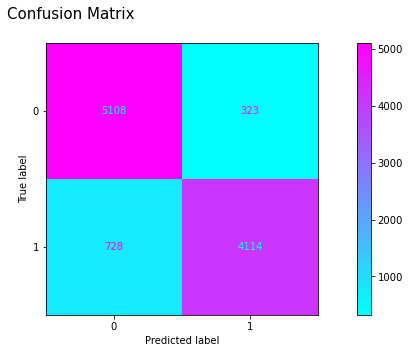

In [22]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = Xception_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['Xception'] = results
#model_results

## InceptionResNetV2



--------------- Model Summary ---------------
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     

                                                                                                  
 batch_normalization_5 (BatchNo  (None, 25, 25, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

                                                                                                  
 activation_21 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 25, 25, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
          

 batch_normalization_37 (BatchN  (None, 25, 25, 32)  96          ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 25, 25, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36

                                                                                                  
 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6

                                                                                                  
 activation_58 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  96          ['conv2d_54[0][0]']              
 ormalizat

 block35_9 (Lambda)             (None, 25, 25, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 25, 25, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
          

 block17_2 (Lambda)             (None, 12, 12, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
          

 block17_4_ac (Activation)      (None, 12, 12, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94

 conv2d_101 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
          

                                                                                                  
 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_11

 batch_normalization_126 (Batch  (None, 12, 12, 160)  480        ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normaliza

 activation_134 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_134[0][0]']
                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normaliza

                                                                                                  
 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
          

 batch_normalization_148 (Batch  (None, 12, 12, 192)  576        ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_1

                                                                                                  
 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
          

 activation_183 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_183[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
          

 block8_8_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normaliza

 conv_7b_bn (BatchNormalization  (None, 5, 5, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 alAveragePooling2D)                                                                              
                                                                                                  
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


--------------- Model Su

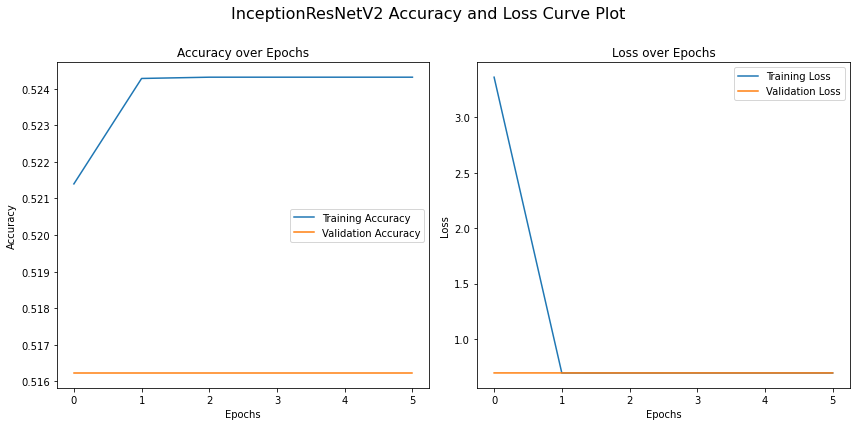

In [23]:
InceptionResNetV2_model = image_model(InceptionResNetV2, 'InceptionResNetV2', 'categorical_crossentropy', 'softmax')

InceptionResNetV2_model.save('models/InceptionResNetV2_model.keras')  

322/322 [==============================] - 428s 1s/step

--------------- Evaluation ---------------
Accuracy: 0.529
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.53      1.00      0.69      5431
    1 - Positive (Pathology)       0.00      0.00      0.00      4842

                    accuracy                           0.53     10273
                   macro avg       0.26      0.50      0.35     10273
                weighted avg       0.28      0.53      0.37     10273


--------------- Visual Evaluation ---------------


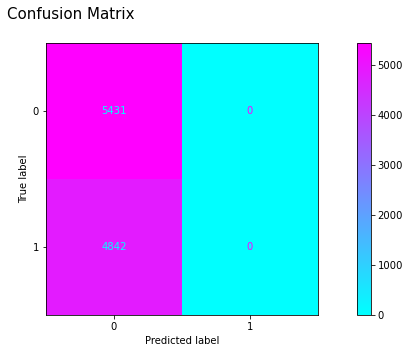

In [24]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = InceptionResNetV2_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionResNetV2'] = results
#model_results

## VGG16

In [ ]:
VGG16_model = image_model(VGG16, 'VGG16', 'categorical_crossentropy', 'softmax')

VGG16_model.save('models/VGG16_model.keras')  

In [ ]:
# generate predictions and evaluate

# make predictions using the xtest dataset
pred = VGG16_model.predict(X_test)

# check the predicition to the corresponding ytest answer
y_pred = np.argmax(pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['VGG16'] = results
#model_results

# Model Results

In [ ]:
model_results.head(10)

In [ ]:
model_results.to_csv('augmented_image_model_results.csv', index=True)